### IMPORTS AND SETUP

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely.wkt
import os, warnings
import logging

logging.basicConfig(filename='warnings.log', level=logging.DEBUG)

def custom_warning_handler(message, category, filename, lineno, file=None, line=None):
    logging.debug(f'{category.__name__}: {message} in {filename}:{lineno}')

warnings.showwarning = custom_warning_handler

from shapely.geometry import Point
import rioxarray as rxr
import rasterio

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor,
    HistGradientBoostingRegressor
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.base import clone
from joblib import dump

import matplotlib.pyplot as plt

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

SHOW_PLOTS = True  # if you want to display some bar charts, etc.

### FEATURE TOGGLES

In [2]:
FEATURE_FLAGS = {
    # building coverage
    "building_cov_50m":  True,
    "building_cov_100m": True,
    "building_cov_200m": True,
    "building_cov_500m": True,

    # distance to water and parks
    "distance_water":     True,
    "distance_parks":     True,

    # street tree coverage
    "street_tree_cov_500m": True,

    # distance to subway
    "dist_to_closest_subway_station": True,

    # raster-based features
    "lst_value":  True,
    "ndvi_value": True,
    "ndbi_value": True,
    "ndwi_value": True,
    "evi_value":  False,  # if you later want to compute EVI from raw bands

    # data fram MapPLUTO
    # "NumBldgs": True, "NumFloors": True, "UnitsRes": True, "UnitsTotal": True,
    # "LotArea": True, "BldgArea": True, "ComArea": True, "ResArea": True,
    # "AssessLand": True, "AssessTot": True, "ExemptTot": True,
    # "BuiltFAR": True, "ResidFAR": True, "CommFAR": True, "FacilFAR": True,
    # "YearBuilt": True, "YearAlter1": True, "YearAlter2": True, "Overlay1": True, 
    # "SPDist1": True, "LandUse": True, "BldgClass": True, "ZoneDist1": True,
    "map_pluto_data": True,

    # disabled features (avoid potential compliance issues)
    "dist_to_closest_calculated_city_centroid": False,
    "location_cluster": False,
    "official_cluster": False,
    "population_density": False,
}

### HELPER FUNCTIONS

In [3]:
def coverage_fraction(geom, polygon_gdf, radius=50):
    """
    coverage_fraction:
      - We do buffer around 'geom' by 'radius'.
      - Clip polygon_gdf with that buffer.
      - Sum area of clipped polygons / area of buffer => coverage fraction.
    """
    buffer_poly = geom.buffer(radius)
    clipped = gpd.clip(polygon_gdf, buffer_poly)
    area_polygons = clipped.geometry.area.sum()
    area_buffer = buffer_poly.area
    return area_polygons / area_buffer if area_buffer > 0 else 0


def building_coverage_fraction(geom, building_gdf, radius=50):
    """Simple wrapper specifically for building footprints coverage."""
    return coverage_fraction(geom, building_gdf, radius)


def distance_to_polygons(geom, poly_gdf):
    dists = poly_gdf.geometry.distance(geom)
    return dists.min() if len(dists) > 0 else np.nan


def extract_raster_value(geom, raster, band_index=1, method="nearest"):
    """Return the pixel value from raster at geom's location."""
    x, y = geom.x, geom.y
    val = raster.sel(x=x, y=y, band=band_index, method=method).values
    return float(val)


def compute_evi(blue, red, nir, L=1.0, C1=6.0, C2=7.5, G=2.5):
    """
    If you want to compute EVI from raw bands.
    Currently not used if 'evi_value' == False.
    """
    return G * (nir - red) / (nir + C1*red - C2*blue + L)

def get_zoning_code(geom, gdf_zoning):
    """
    Return the zoning code from gdf_zoning polygon that contains 'geom'.
    If multiple polygons or none found, handle accordingly.
    """
    # Create a one-row GeoDataFrame for the point
    pt = gpd.GeoDataFrame([1], geometry=[geom], crs=gdf_zoning.crs)
    join_res = gpd.sjoin(pt, gdf_zoning, how="left", predicate="within")
    if len(join_res) == 0:
        return "NONE"
    else:
        # Return the zoning code column, e.g., 'ZONEDIST'
        return join_res.iloc[0]["ZONEDIST"]

def get_pluto_features(geom, gdf_pluto, pluto_columns, initial_buffer=1.0, max_buffer=16.0):
    """
    For a given point geometry, first try to find a PLUTO polygon that contains it.
    If none is found, gradually increase the buffer until max_buffer is reached.
    Returns a dictionary of values for the specified pluto_columns.
    """
    buffer_distance = initial_buffer
    candidate_idx = list(gdf_pluto.sindex.query(geom, predicate="within"))
    
    # Gradually increase the buffer if no candidate is found
    while not candidate_idx and buffer_distance <= max_buffer:
        candidate_idx = list(gdf_pluto.sindex.query(geom.buffer(buffer_distance), predicate="intersects"))
        buffer_distance *= 2  # Double the buffer and try again
    
    if not candidate_idx:
        return {col: np.nan for col in pluto_columns}
    
    # If multiple candidates, select the one with the largest intersection area.
    # For a point (or near-point) this may not be very informative, so we choose the first.
    best_match = gdf_pluto.iloc[candidate_idx[0]]
    return best_match[pluto_columns].to_dict()

In [4]:
# Define the list of PLUTO columns you wish to extract.
pluto_columns = [
    "NumBldgs", "NumFloors", "UnitsRes", "UnitsTotal",
    "LotArea", "BldgArea", "ComArea", "ResArea",
    "AssessLand", "AssessTot", "ExemptTot",
    "BuiltFAR", "ResidFAR", "CommFAR", "FacilFAR",
    "YearBuilt", "YearAlter1", "YearAlter2",
    "Overlay1", "SPDist1", "LandUse", "BldgClass", "ZoneDist1"
]

### LOAD GEOSPATIAL DATA

In [5]:
print("Loading building footprints, water, parks, street trees, subway stations...")

# 4.1 Building footprints
gdf_buildings = gpd.read_file("./data/Building_Footprint.kml").to_crs("EPSG:2263")

# 4.2 Water polygons
df_water = pd.read_csv("./data/NYC_Planimetric_Database__Hydrography_20250123.csv")
df_water["geometry"] = df_water["the_geom"].apply(shapely.wkt.loads)
gdf_water = gpd.GeoDataFrame(df_water, geometry="geometry", crs="EPSG:4326").to_crs("EPSG:2263")

# 4.3 Parks polygons
gdf_parks = gpd.read_file("./data/Parks_Properties_20250123.kml").to_crs("EPSG:2263")

# 4.4 Street Trees
df_trees = pd.read_csv("./data/2015_Street_Tree_Census_-_Tree_Data_20250205.csv")
df_trees.rename(columns={"latitude": "lat", "longitude": "lon"}, inplace=True)
gdf_trees_pts = gpd.GeoDataFrame(
    df_trees,
    geometry=[Point(lon, lat) for lon, lat in zip(df_trees["lon"], df_trees["lat"])],
    crs="EPSG:4326"
).to_crs("EPSG:2263")
# approximate canopy with 2m buffer
gdf_trees_poly = gdf_trees_pts.copy()
gdf_trees_poly["geometry"] = gdf_trees_poly.geometry.buffer(2.0)

# 4.5 Subway stations
gdf_stations = gpd.read_file("./data/MTA Subway Stations_20250206.geojson").to_crs("EPSG:2263")

# 4.6 MapPLUTO
gdf_pluto = gpd.read_file("./data/MapPLUTO.shp")

print("Done loading geospatial data.")

Loading building footprints, water, parks, street trees, subway stations...
Done loading geospatial data.


In [6]:
gdf_buildings["original_index"] = gdf_buildings.index  # before the join

# Then do the spatial join
joined = gpd.sjoin(gdf_buildings, gdf_pluto, how="left", predicate="intersects")

# Count how many times each building index appears
dupes = joined.groupby("original_index").size()
dupes[dupes > 1].sort_values(ascending=False).head(10)

original_index
7465    81
6686    76
7461    69
9158    68
8602    65
7750    64
8434    64
8460    64
8410    63
8320    63
dtype: int64

In [7]:
gdf_buildings = joined.drop_duplicates(subset=["original_index"])
gdf_buildings.columns

Index(['Name', 'Description', 'geometry', 'original_index', 'index_right',
       'Borough', 'Block', 'Lot', 'CD', 'BCT2020', 'BCTCB2020', 'CT2010',
       'CB2010', 'SchoolDist', 'Council', 'ZipCode', 'FireComp', 'PolicePrct',
       'HealthCent', 'HealthArea', 'Sanitboro', 'SanitDistr', 'SanitSub',
       'Address', 'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4',
       'Overlay1', 'Overlay2', 'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight',
       'SplitZone', 'BldgClass', 'LandUse', 'Easements', 'OwnerType',
       'OwnerName', 'LotArea', 'BldgArea', 'ComArea', 'ResArea', 'OfficeArea',
       'RetailArea', 'GarageArea', 'StrgeArea', 'FactryArea', 'OtherArea',
       'AreaSource', 'NumBldgs', 'NumFloors', 'UnitsRes', 'UnitsTotal',
       'LotFront', 'LotDepth', 'BldgFront', 'BldgDepth', 'Ext', 'ProxCode',
       'IrrLotCode', 'LotType', 'BsmtCode', 'AssessLand', 'AssessTot',
       'ExemptTot', 'YearBuilt', 'YearAlter1', 'YearAlter2', 'HistDist',
       'Landmark', 'BuiltFAR', 'Res

In [8]:
gdf_buildings["ZoneDist1"] = gdf_buildings["ZoneDist1"].fillna("UNKNOWN")
gdf_buildings["Overlay1"] = gdf_buildings["Overlay1"].fillna("UNKNOWN")
gdf_buildings["SPDist1"] = gdf_buildings["SPDist1"].fillna("UNKNOWN")
gdf_buildings["BldgClass"] = gdf_buildings["BldgClass"].fillna("UNKNOWN")
gdf_buildings["Borough"] = gdf_buildings["Borough"].fillna("OTHER")
median_val_num_floors = gdf_buildings["NumFloors"].median()
gdf_buildings["NumFloors"] = gdf_buildings["NumFloors"].fillna(median_val_num_floors)
median_val_num_bldgs = gdf_buildings["NumBldgs"].median()
gdf_buildings["NumBldgs"] = gdf_buildings["NumBldgs"].fillna(median_val_num_bldgs)
median_val_num_units_res = gdf_buildings["UnitsRes"].median()
gdf_buildings["UnitsRes"] = gdf_buildings["UnitsRes"].fillna(median_val_num_units_res)
median_val_num_units_total = gdf_buildings["UnitsTotal"].median()
gdf_buildings["UnitsTotal"] = gdf_buildings["UnitsTotal"].fillna(median_val_num_units_total)
median_val_lot_area = gdf_buildings["LotArea"].median()
gdf_buildings["LotArea"] = gdf_buildings["LotArea"].fillna(median_val_lot_area)
median_val_bldg_area = gdf_buildings["BldgArea"].median()
gdf_buildings["BldgArea"] = gdf_buildings["BldgArea"].fillna(median_val_bldg_area)
median_val_com_area = gdf_buildings["ComArea"].median()
gdf_buildings["ComArea"] = gdf_buildings["ComArea"].fillna(median_val_com_area)
median_val_res_area = gdf_buildings["ResArea"].median()
gdf_buildings["ResArea"] = gdf_buildings["ResArea"].fillna(median_val_res_area)
median_val_assess_land = gdf_buildings["AssessLand"].median()
gdf_buildings["AssessLand"] = gdf_buildings["AssessLand"].fillna(median_val_assess_land)
median_val_assess_tot = gdf_buildings["AssessTot"].median()
gdf_buildings["AssessTot"] = gdf_buildings["AssessTot"].fillna(median_val_assess_tot)
median_val_exempt_tot = gdf_buildings["ExemptTot"].median()
gdf_buildings["ExemptTot"] = gdf_buildings["ExemptTot"].fillna(median_val_exempt_tot)
median_val_built_far = gdf_buildings["BuiltFAR"].median()
gdf_buildings["BuiltFAR"] = gdf_buildings["BuiltFAR"].fillna(median_val_built_far)
median_val_resid_far = gdf_buildings["ResidFAR"].median()
gdf_buildings["ResidFAR"] = gdf_buildings["ResidFAR"].fillna(median_val_resid_far)
median_val_comm_far = gdf_buildings["CommFAR"].median()
gdf_buildings["CommFAR"] = gdf_buildings["CommFAR"].fillna(median_val_comm_far)
median_val_facil_far = gdf_buildings["FacilFAR"].median()
gdf_buildings["FacilFAR"] = gdf_buildings["FacilFAR"].fillna(median_val_facil_far)
median_val_year_built = gdf_buildings["YearBuilt"].median()
gdf_buildings["YearBuilt"] = gdf_buildings["YearBuilt"].fillna(median_val_year_built)
median_val_year_alter_1 = gdf_buildings["YearAlter1"].median()
gdf_buildings["YearAlter1"] = gdf_buildings["YearAlter1"].fillna(median_val_year_alter_1)
median_val_year_alter_2 = gdf_buildings["YearAlter2"].median()
gdf_buildings["YearAlter2"] = gdf_buildings["YearAlter1"].fillna(median_val_year_alter_1)

In [9]:
columns_with_nan = gdf_buildings.columns[gdf_buildings.isna().any()].tolist()
print("Columns with at least one NaN:", columns_with_nan)

Columns with at least one NaN: ['index_right', 'Block', 'Lot', 'CD', 'BCT2020', 'BCTCB2020', 'CT2010', 'CB2010', 'SchoolDist', 'Council', 'ZipCode', 'FireComp', 'PolicePrct', 'HealthCent', 'HealthArea', 'Sanitboro', 'SanitDistr', 'SanitSub', 'Address', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4', 'Overlay2', 'SPDist2', 'SPDist3', 'LtdHeight', 'SplitZone', 'LandUse', 'Easements', 'OwnerType', 'OwnerName', 'OfficeArea', 'RetailArea', 'GarageArea', 'StrgeArea', 'FactryArea', 'OtherArea', 'AreaSource', 'LotFront', 'LotDepth', 'BldgFront', 'BldgDepth', 'Ext', 'ProxCode', 'IrrLotCode', 'LotType', 'BsmtCode', 'HistDist', 'Landmark', 'BoroCode', 'BBL', 'CondoNo', 'Tract2010', 'XCoord', 'YCoord', 'ZoneMap', 'ZMCode', 'Sanborn', 'TaxMap', 'EDesigNum', 'APPBBL', 'APPDate', 'PLUTOMapID', 'FIRM07_FLA', 'PFIRM15_FL', 'Version', 'DCPEdited', 'Latitude', 'Longitude', 'Notes', 'Shape_Leng', 'Shape_Area']


In [10]:
gdf_buildings = gdf_buildings.dropna(axis=1)

In [11]:
gdf_buildings.count()

Name              9436
Description       9436
geometry          9436
original_index    9436
Borough           9436
ZoneDist1         9436
Overlay1          9436
SPDist1           9436
BldgClass         9436
LotArea           9436
BldgArea          9436
ComArea           9436
ResArea           9436
NumBldgs          9436
NumFloors         9436
UnitsRes          9436
UnitsTotal        9436
AssessLand        9436
AssessTot         9436
ExemptTot         9436
YearBuilt         9436
YearAlter1        9436
YearAlter2        9436
BuiltFAR          9436
ResidFAR          9436
CommFAR           9436
FacilFAR          9436
dtype: int64

In [12]:
gdf_buildings.describe()

,original_index,LotArea,BldgArea,ComArea,ResArea,NumBldgs,NumFloors,UnitsRes,UnitsTotal,AssessLand,AssessTot,ExemptTot,YearBuilt,YearAlter1,YearAlter2,BuiltFAR,ResidFAR,CommFAR,FacilFAR
count,9436.000000,9.436000e+03,9.436000e+03,9.436000e+03,9.436000e+03,9436.000000,9436.000000,9436.000000,9436.000000,9.436000e+03,9.436000e+03,9.436000e+03,9436.000000,9436.000000,9436.000000,9436.000000,9436.000000,9436.000000,9436.000000
mean,4717.500000,4.231548e+05,1.345366e+05,5.551928e+04,7.752586e+04,3.559771,5.351408,99.479864,101.859262,1.798262e+07,2.959286e+07,2.623047e+07,1778.198389,657.450191,657.450191,2.714347,3.567008,0.613173,5.155394
std,2724.082904,2.977558e+06,5.569787e+05,4.519657e+05,2.893176e+05,13.244404,6.646124,535.342277,539.445512,2.079726e+08,2.449089e+08,2.440179e+08,540.822398,938.880634,938.880634,3.163861,2.399072,1.931568,2.331052
min,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2358.750000,2.592000e+03,2.925000e+03,0.000000e+00,0.000000e+00,1.000000,2.000000,0.000000,1.000000,1.290000e+04,6.312000e+04,0.000000e+00,1910.000000,0.000000,0.000000,0.860000,2.430000,0.000000,4.800000
50%,4717.500000,7.400000e+03,1.120250e+04,0.000000e+00,3.000000e+03,1.000000,3.000000,3.000000,3.000000,1.062000e+05,6.954750e+05,0.000000e+00,1928.000000,0.000000,0.000000,1.670000,3.440000,0.000000,4.800000
75%,7076.250000,2.566325e+04,6.373200e+04,5.323250e+03,3.466425e+04,2.000000,6.000000,38.000000,41.000000,5.229000e+05,3.748275e+06,9.536400e+05,1962.000000,1987.000000,1987.000000,3.870000,4.000000,0.000000,6.500000
max,9435.000000,3.659000e+07,1.343508e+07,1.343508e+07,3.739745e+06,204.000000,98.000000,8018.000000,8088.000000,2.855118e+09,3.296988e+09,3.296988e+09,2024.000000,2024.000000,2024.000000,34.360000,10.000000,15.000000,15.000000


46835


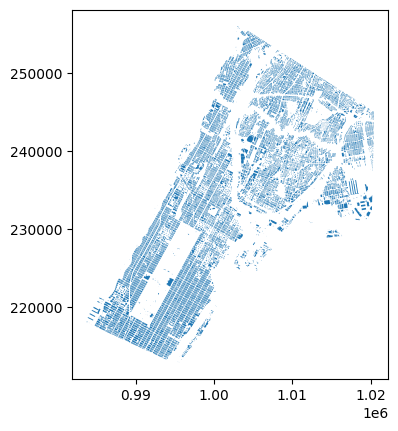

In [13]:
if SHOW_PLOTS:
    overlay_df = gpd.overlay(gdf_buildings, gdf_pluto, how="intersection")
    print(len(overlay_df))
    overlay_df.plot()

### LOAD + CHECK RASTERS

In [14]:
print("Loading reprojected LST + Indices...")

lst_raster = rxr.open_rasterio("Landsat_LST_v4_single_0601_0901.tiff")
lst_raster_2263 = lst_raster.rio.reproject("EPSG:2263")

indices_raster = rxr.open_rasterio("S2_indices_v4_single_0601_0901.tiff")
indices_raster_2263 = indices_raster.rio.reproject("EPSG:2263")

# Quick check for valid data
ratio_lst = (~lst_raster_2263.isnull()).mean().values
ratio_idx = (~indices_raster_2263.isnull()).mean().values

print(f"LST valid ratio: {ratio_lst:.3f}")
print(f"Indices valid ratio: {ratio_idx:.3f}")
if ratio_lst == 0.0:
    print("WARNING: LST raster is entirely NaN.")
if ratio_idx == 0.0:
    print("WARNING: Indices raster is entirely NaN.")

print("LST raster bounds:", lst_raster_2263.rio.bounds())
print("Indices raster bounds:", indices_raster_2263.rio.bounds())

Loading reprojected LST + Indices...
LST valid ratio: 1.000
Indices valid ratio: 0.998
LST raster bounds: (981437.4489166049, 212457.54099916507, 1023088.2146540903, 260009.54459268012)
Indices raster bounds: (981462.3462672028, 212512.28574393364, 1023050.6163433938, 259944.0070645518)


### LOAD TRAINING DATA

In [15]:
print("Loading Training CSV ...")
df_train = pd.read_csv("./data/Training_data_uhi_index_UHI2025-v2.csv")
print("df_train shape:", df_train.shape)
gdf_train_csv = gpd.GeoDataFrame(
    df_train,
    geometry=[Point(lon, lat) for lon, lat in zip(df_train["Longitude"], df_train["Latitude"])],
    crs="EPSG:4326"
).to_crs("EPSG:2263")
# Optionally, if your training CSV is a subset of your building footprints,
# you can use a nearest spatial join; however, here we choose to extract features row-by-row.
gdf_train = gdf_train_csv.copy()  # We'll enrich this gdf row-by-row.

# --- Prepare dictionaries for per-point features and for PLUTO features.
# For per-point features (computed row-by-row):
features_dict_train = {key: [] for key, val in FEATURE_FLAGS.items() if val and key != "map_pluto_data"}

# For MapPLUTO features, initialize a dictionary with keys = pluto_columns.
pluto_features_dict = {col: [] for col in pluto_columns}

total_rows = len(gdf_train)
print(f"total rows: {total_rows}")

Loading Training CSV ...
df_train shape: (11229, 4)
total rows: 11229


In [16]:
# import geopandas as gpd
# from shapely.geometry import box

# # 1. Extract the total bounds of gdf_train
# minx_train, miny_train, maxx_train, maxy_train = gdf_train.total_bounds

# # 2. Define a buffer in the same units as your CRS (here, meters)
# buffer = 1000  # adjust this value if you need a slightly larger or smaller margin

# # 3. Create an expanded bounding box
# expanded_bbox = box(minx_train - buffer, 
#                     miny_train - buffer, 
#                     maxx_train + buffer, 
#                     maxy_train + buffer)

# # Optional: If you want to see the coordinates of the expanded bounding box:
# print("Expanded Bounding Box:", expanded_bbox.bounds)

# # 4. Create a sub-dataframe from gdf_buildings 1GB that only contains features intersecting the expanded bbox
# gdf_buildings = gdf_buildings[gdf_buildings.geometry.intersects(expanded_bbox)]
# gdf_buildings['centroid'] = gdf_buildings.geometry.centroid

# # Check the total bounds of the new subset
# print("Subset Total Bounds:", gdf_buildings.total_bounds)
# print("Train Total Bounds:", gdf_train.total_bounds)

In [17]:
# # Find the centroid of the largest cluster of building points.
# coords = np.column_stack([gdf_buildings.centroid.x, gdf_buildings.centroid.y]) # Extract coordinates from centroids

# # Cluster building points using DBSCAN
# # These parameters are chosen to merge clusters (e.g., Manhattan and Bronx) in NYC.
# eps_m = 400   # maximum distance (in meters) to consider two points as neighbors
# min_samples = 10  # minimum number of points required to form a cluster
# db = DBSCAN(eps=eps_m, min_samples=min_samples).fit(coords)
# labels = db.labels_
# gdf_buildings['cluster'] = labels

# # Determine the largest cluster (ignoring noise, which is labeled -1)
# valid_mask = (labels >= 0)
# if np.any(valid_mask):
#     unique_labels, counts = np.unique(labels[valid_mask], return_counts=True)
#     largest_label = unique_labels[np.argmax(counts)]
#     in_largest = coords[labels == largest_label]
#     if len(in_largest) > 0:
#         city_centroid = MultiPoint(in_largest).centroid
#     else:
#         city_centroid = MultiPoint(coords).centroid
# else:
#     city_centroid = MultiPoint(coords).centroid

# city_x, city_y = city_centroid.x, city_centroid.y
# print(f"Centroid of the largest cluster of buildings in the city x/y: {city_x}, {city_y}")

# if SHOW_PLOTS:
#     # Plot all building centroids colored by their cluster labels, and overlay the city centroid
#     fig, ax = plt.subplots(figsize=(10, 8))
    
#     # Scatter plot: Use a colormap (e.g., 'tab20') to distinguish different clusters.
#     # Noise points (label -1) will get their own color.
#     scatter = ax.scatter(
#         coords[:, 0], 
#         coords[:, 1], 
#         c=labels, 
#         cmap='tab20', 
#         s=10, 
#         alpha=0.6,
#         label="Building Centroids"
#     )
    
#     # Overlay the city centroid as a large red star
#     ax.scatter(city_centroid.x, city_centroid.y, color='red', marker='*', s=200, label='City Centroid')
    
#     ax.set_title("Building Clusters and City Centroid")
#     ax.set_xlabel("X coordinate")
#     ax.set_ylabel("Y coordinate")
#     ax.legend()
#     plt.colorbar(scatter, ax=ax, label="Cluster Label")
#     plt.show()

### BUILD TRAINING FEATURES

In [18]:
print("Building training features...")

# We'll store arrays in a dictionary keyed exactly by the same name as FEATURE_FLAGS
features_dict_train = {key: [] for key, val in FEATURE_FLAGS.items() if val and key != "map_pluto_data"}
# (Only create arrays for the flags that are True)

total_rows = len(gdf_train)
print(f"total rows: {total_rows}")

for i, row in gdf_train.iterrows():
    if i % 1000 == 0:
        percent_done = (i / total_rows) * 100
        print(f"  -> {percent_done:.2f}% done")

    geom = row.geometry

    # 7.1 building coverage (various radii)
    if FEATURE_FLAGS["building_cov_50m"]:
        b50 = building_coverage_fraction(geom, gdf_buildings, 50)
        features_dict_train["building_cov_50m"].append(b50)

    if FEATURE_FLAGS["building_cov_100m"]:
        b100 = building_coverage_fraction(geom, gdf_buildings, 100)
        features_dict_train["building_cov_100m"].append(b100)

    if FEATURE_FLAGS["building_cov_200m"]:
        b200 = building_coverage_fraction(geom, gdf_buildings, 200)
        features_dict_train["building_cov_200m"].append(b200)

    if FEATURE_FLAGS["building_cov_500m"]:
        b500 = building_coverage_fraction(geom, gdf_buildings, 500)
        features_dict_train["building_cov_500m"].append(b500)

    # 7.2 distance_water
    if FEATURE_FLAGS["distance_water"]:
        dist_w = distance_to_polygons(geom, gdf_water)
        features_dict_train["distance_water"].append(dist_w)

    # 7.3 distance_parks
    if FEATURE_FLAGS["distance_parks"]:
        dist_p = distance_to_polygons(geom, gdf_parks)
        features_dict_train["distance_parks"].append(dist_p)

    # 7.4 street_tree_cov_500m
    if FEATURE_FLAGS["street_tree_cov_500m"]:
        tree_500 = coverage_fraction(geom, gdf_trees_poly, 500)
        features_dict_train["street_tree_cov_500m"].append(tree_500)

    # 7.5 dist_to_closest_subway_station
    if FEATURE_FLAGS["dist_to_closest_subway_station"]:
        dists_subway = gdf_stations.geometry.distance(geom)
        dist_sub = dists_subway.min() if len(dists_subway) > 0 else 0
        features_dict_train["dist_to_closest_subway_station"].append(dist_sub)

    # 7.6 Raster-based: lst_value, ndvi_value, ndbi_value, ndwi_value
    if FEATURE_FLAGS["lst_value"]:
        lst_val = extract_raster_value(geom, lst_raster_2263, band_index=1)
        features_dict_train["lst_value"].append(lst_val)

    if FEATURE_FLAGS["ndvi_value"]:
        ndvi_val = extract_raster_value(geom, indices_raster_2263, band_index=1)
        features_dict_train["ndvi_value"].append(ndvi_val)

    if FEATURE_FLAGS["ndbi_value"]:
        ndbi_val = extract_raster_value(geom, indices_raster_2263, band_index=2)
        features_dict_train["ndbi_value"].append(ndbi_val)

    if FEATURE_FLAGS["ndwi_value"]:
        ndwi_val = extract_raster_value(geom, indices_raster_2263, band_index=3)
        features_dict_train["ndwi_value"].append(ndwi_val)

    # 7.7 evi_value - if set to True (currently False), we would compute it from raw bands
    # if FEATURE_FLAGS["evi_value"]:
    #     features_dict_train["evi_value"].append(evi_val)

    # 7.8 extract PLUTO features
    if FEATURE_FLAGS["map_pluto_data"]:
        pluto_feats = get_pluto_features(geom, gdf_pluto, pluto_columns)
        for col in pluto_columns:
            pluto_features_dict[col].append(pluto_feats.get(col, np.nan))

print("100.00% done")

Building training features...
total rows: 11229
  -> 0.00% done
  -> 8.91% done
  -> 17.81% done
  -> 26.72% done
  -> 35.62% done
  -> 44.53% done
  -> 53.43% done
  -> 62.34% done
  -> 71.24% done
  -> 80.15% done
  -> 89.06% done
  -> 97.96% done
100.00% done


In [19]:
test_geom = gdf_train.iloc[0].geometry
print(get_pluto_features(test_geom, gdf_pluto, pluto_columns))

{'NumBldgs': nan, 'NumFloors': nan, 'UnitsRes': nan, 'UnitsTotal': nan, 'LotArea': nan, 'BldgArea': nan, 'ComArea': nan, 'ResArea': nan, 'AssessLand': nan, 'AssessTot': nan, 'ExemptTot': nan, 'BuiltFAR': nan, 'ResidFAR': nan, 'CommFAR': nan, 'FacilFAR': nan, 'YearBuilt': nan, 'YearAlter1': nan, 'YearAlter2': nan, 'Overlay1': nan, 'SPDist1': nan, 'LandUse': nan, 'BldgClass': nan, 'ZoneDist1': nan}


In [20]:
print("PLUTO bounds:", gdf_pluto.total_bounds)
print("Training points bounds:", gdf_train.total_bounds)
print("Test point:", test_geom)
print(gdf_pluto.crs)
print(gdf_train.crs)
print(gdf_pluto[pluto_columns].isna().sum())

PLUTO bounds: [ 913128.92637062  120048.98595905 1067335.95135403  272811.18305349]
Training points bounds: [ 985785.41138281  215727.52933294 1017620.84024546  252422.67726363]
Test point: POINT (1009393.6056238374 235526.82444258165)
EPSG:2263
EPSG:2263
NumBldgs           0
NumFloors          0
UnitsRes           0
UnitsTotal         0
LotArea            0
BldgArea           0
ComArea            0
ResArea            0
AssessLand         0
AssessTot          0
ExemptTot          0
BuiltFAR           0
ResidFAR           0
CommFAR            0
FacilFAR           0
YearBuilt          0
YearAlter1         0
YearAlter2         0
Overlay1      782315
SPDist1       751181
LandUse         2635
BldgClass        339
ZoneDist1         13
dtype: int64


### CREATE TRAINING DATAFRAME

In [21]:
# all_feature_keys = [k for k, v in FEATURE_FLAGS.items() if v]
# feature_cols = [col for col in all_feature_keys if col in gdf_train.columns]
# print("Feature columns used:", feature_cols)

# df_train_feat = gdf_train[feature_cols].fillna(0.0)
# X = df_train_feat.values
# y = gdf_train["UHI Index"].values

# print("Final train feature shape:", X.shape)

# --- Add per-point features to gdf_train
for feat_key, feat_values in features_dict_train.items():
    print(feat_key)
    gdf_train[feat_key] = feat_values
    print(f"Per-point: {feat_key}: {len(feat_values)}")

# --- Add PLUTO features to gdf_train
for col, values in pluto_features_dict.items():
    gdf_train[col] = values
    print(f"PLUTO: {col}: {len(values)}")

# --- Process categorical PLUTO columns via one-hot encoding
map_pluto_cat_cols = ["Overlay1", "SPDist1", "LandUse", "BldgClass", "ZoneDist1"]
# Ensure these columns are strings
for col in map_pluto_cat_cols:
    gdf_train[col] = gdf_train[col].astype(str)

# One-hot encode categorical PLUTO columns
pluto_dummies = pd.get_dummies(gdf_train[map_pluto_cat_cols], prefix=map_pluto_cat_cols)
# Optionally, you can drop the original categorical columns:
gdf_train = gdf_train.drop(columns=map_pluto_cat_cols)
# Concatenate the dummy columns with the existing dataframe:
gdf_train = pd.concat([gdf_train, pluto_dummies], axis=1)
print("One-hot encoded PLUTO categorical features added.")
    
# --- Build final global feature list
# The per-point features come from features_dict_train.
per_point_features = list(features_dict_train.keys())
# The PLUTO numeric features come from pluto_columns (excluding the ones that were one-hot encoded)
pluto_numeric_features = [col for col in pluto_columns if col not in map_pluto_cat_cols]
# And then add the names of the dummy columns:
pluto_dummy_features = list(pluto_dummies.columns)

final_feature_cols = per_point_features + pluto_numeric_features + pluto_dummy_features
print("Final feature columns used:")
print(final_feature_cols)

df_train_feat = gdf_train[final_feature_cols].fillna(0.0)
X = df_train_feat.values
y = gdf_train["UHI Index"].values

print("Final train feature shape:", X.shape)

building_cov_50m
Per-point: building_cov_50m: 11229
building_cov_100m
Per-point: building_cov_100m: 11229
building_cov_200m
Per-point: building_cov_200m: 11229
building_cov_500m
Per-point: building_cov_500m: 11229
distance_water
Per-point: distance_water: 11229
distance_parks
Per-point: distance_parks: 11229
street_tree_cov_500m
Per-point: street_tree_cov_500m: 11229
dist_to_closest_subway_station
Per-point: dist_to_closest_subway_station: 11229
lst_value
Per-point: lst_value: 11229
ndvi_value
Per-point: ndvi_value: 11229
ndbi_value
Per-point: ndbi_value: 11229
ndwi_value
Per-point: ndwi_value: 11229
PLUTO: NumBldgs: 11229
PLUTO: NumFloors: 11229
PLUTO: UnitsRes: 11229
PLUTO: UnitsTotal: 11229
PLUTO: LotArea: 11229
PLUTO: BldgArea: 11229
PLUTO: ComArea: 11229
PLUTO: ResArea: 11229
PLUTO: AssessLand: 11229
PLUTO: AssessTot: 11229
PLUTO: ExemptTot: 11229
PLUTO: BuiltFAR: 11229
PLUTO: ResidFAR: 11229
PLUTO: CommFAR: 11229
PLUTO: FacilFAR: 11229
PLUTO: YearBuilt: 11229
PLUTO: YearAlter1: 1

### OUTLIER REMOVAL

In [22]:
# E.g. cap y above 99.5th percentile
cap_quantile= 0.995
cap_val= gdf_train["UHI Index"].quantile(cap_quantile)
mask_out= (gdf_train["UHI Index"] > cap_val)
if mask_out.sum()>0:
    print(f"Capping {mask_out.sum()} outliers above Q={cap_quantile} at {cap_val:.3f}")
    gdf_train.loc[mask_out, "UHI Index"] = cap_val

Capping 57 outliers above Q=0.995 at 1.041


In [23]:
df_train_feat.describe()

,building_cov_50m,building_cov_100m,building_cov_200m,building_cov_500m,distance_water,distance_parks,street_tree_cov_500m,dist_to_closest_subway_station,lst_value,ndvi_value,...,AssessLand,AssessTot,ExemptTot,BuiltFAR,ResidFAR,CommFAR,FacilFAR,YearBuilt,YearAlter1,YearAlter2
count,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,...,1.122900e+04,1.122900e+04,1.122900e+04,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000
mean,0.125190,0.228201,0.303530,0.321961,1891.184531,362.798049,0.001550,1346.473005,40.654181,-0.006387,...,1.535363e+08,1.818400e+08,1.799336e+08,1.163634,1.365081,0.339674,1.805254,539.317125,267.347760,42.383828
std,0.175080,0.185421,0.188678,0.162210,1298.246512,360.343364,0.000785,909.205876,2.714054,0.062528,...,6.413661e+08,7.401714e+08,7.405119e+08,2.874290,2.738912,1.346739,3.136187,870.870843,679.877779,288.661211
min,0.000000,0.000000,0.000000,0.000000,20.933619,0.000000,0.000000,7.600310,32.484185,-0.231795,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.058977,0.166868,0.226159,930.568027,76.262961,0.001008,735.246718,39.227938,-0.037236,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.048059,0.215740,0.311991,0.325088,1617.923389,284.983308,0.001570,1125.301971,40.868588,-0.019680,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.198378,0.350740,0.435660,0.424041,2415.031074,505.198800,0.002091,1725.086477,42.341754,0.006772,...,2.259000e+05,1.494000e+06,0.000000e+00,0.460000,0.000000,0.000000,4.000000,1902.000000,0.000000,0.000000
max,1.000000,0.999675,0.824851,0.679903,6041.065986,1998.456627,0.003626,6033.752229,54.564594,0.562697,...,2.855118e+09,3.296988e+09,3.296988e+09,29.450000,10.000000,15.000000,15.000000,2024.000000,2023.000000,2023.000000


In [24]:
df_train_feat

,building_cov_50m,building_cov_100m,building_cov_200m,building_cov_500m,distance_water,distance_parks,street_tree_cov_500m,dist_to_closest_subway_station,lst_value,ndvi_value,...,ZoneDist1_R7A,ZoneDist1_R7B,ZoneDist1_R7D,ZoneDist1_R7X,ZoneDist1_R8,ZoneDist1_R8A,ZoneDist1_R8B,ZoneDist1_R9,ZoneDist1_R9A,ZoneDist1_nan
0,0.019848,0.119473,0.248509,0.335381,3536.717021,371.277131,0.001072,1288.844077,41.442815,-0.032849,...,False,False,False,False,False,False,False,False,False,True
1,0.039795,0.159338,0.260397,0.331488,3520.867715,358.889116,0.001084,1311.950618,41.442815,-0.017685,...,False,False,False,False,False,False,False,False,False,True
2,0.026731,0.194538,0.278762,0.329066,3504.846309,344.200944,0.001075,1337.471817,41.442815,-0.023479,...,False,False,False,False,False,False,False,False,False,True
3,0.020690,0.227561,0.312600,0.330401,3487.673871,330.119247,0.001026,1364.019827,41.152283,-0.024157,...,False,False,False,False,False,False,False,False,False,True
4,0.049321,0.263256,0.351619,0.335427,3470.826136,320.290749,0.000978,1387.305279,41.152283,-0.024157,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11224,0.000000,0.000000,0.000000,0.000000,569.780991,0.000000,0.000000,2170.218829,34.890471,0.028827,...,False,False,False,False,False,False,False,False,False,False
11225,0.000000,0.000000,0.000000,0.000000,559.973656,0.000000,0.000000,2168.641060,34.890471,0.051500,...,False,False,False,False,False,False,False,False,False,False
11226,0.000000,0.000000,0.000000,0.000000,543.787136,0.000000,0.000000,2163.730048,34.890471,0.051500,...,False,False,False,False,False,False,False,False,False,False
11227,0.000000,0.000000,0.000000,0.000000,536.117477,0.000000,0.000000,2160.203993,34.890471,0.048808,...,False,False,False,False,False,False,False,False,False,False


In [25]:
gdf_train.describe()

,Longitude,Latitude,UHI Index,building_cov_50m,building_cov_100m,building_cov_200m,building_cov_500m,distance_water,distance_parks,street_tree_cov_500m,...,AssessLand,AssessTot,ExemptTot,BuiltFAR,ResidFAR,CommFAR,FacilFAR,YearBuilt,YearAlter1,YearAlter2
count,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,...,4.132000e+03,4.132000e+03,4.132000e+03,4132.000000,4132.000000,4132.000000,4132.000000,4132.000000,4132.000000,4132.000000
mean,-73.933927,40.808800,0.999989,0.125190,0.228201,0.303530,0.321961,1891.184531,362.798049,0.001550,...,4.172456e+08,4.941631e+08,4.889823e+08,3.162258,3.709705,0.923088,4.905905,1465.632139,726.536302,115.181026
std,0.028253,0.023171,0.016205,0.175080,0.185421,0.188678,0.162210,1298.246512,360.343364,0.000785,...,1.003985e+09,1.155285e+09,1.157270e+09,4.016598,3.418975,2.095461,3.393821,838.688504,960.545188,467.001173
min,-73.994457,40.758792,0.956122,0.000000,0.000000,0.000000,0.000000,20.933619,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-73.955703,40.790905,0.988577,0.000000,0.058977,0.166868,0.226159,930.568027,76.262961,0.001008,...,1.358100e+05,9.247500e+05,0.000000e+00,0.000000,0.000000,0.000000,2.400000,1869.000000,0.000000,0.000000
50%,-73.932968,40.810688,1.000237,0.048059,0.215740,0.311991,0.325088,1617.923389,284.983308,0.001570,...,9.877485e+05,5.361300e+06,2.602240e+05,1.980000,3.440000,0.000000,4.800000,1925.000000,0.000000,0.000000
75%,-73.909647,40.824515,1.011176,0.198378,0.350740,0.435660,0.424041,2415.031074,505.198800,0.002091,...,7.236004e+06,3.193515e+07,2.033505e+07,4.295000,6.020000,2.000000,6.500000,1958.000000,1987.000000,0.000000
max,-73.879458,40.859497,1.040817,1.000000,0.999675,0.824851,0.679903,6041.065986,1998.456627,0.003626,...,2.855118e+09,3.296988e+09,3.296988e+09,29.450000,10.000000,15.000000,15.000000,2024.000000,2023.000000,2023.000000


In [26]:
gdf_train

,Longitude,Latitude,datetime,UHI Index,geometry,building_cov_50m,building_cov_100m,building_cov_200m,building_cov_500m,distance_water,...,ZoneDist1_R7A,ZoneDist1_R7B,ZoneDist1_R7D,ZoneDist1_R7X,ZoneDist1_R8,ZoneDist1_R8A,ZoneDist1_R8B,ZoneDist1_R9,ZoneDist1_R9A,ZoneDist1_nan
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,POINT (1009393.606 235526.824),0.019848,0.119473,0.248509,0.335381,3536.717021,...,False,False,False,False,False,False,False,False,False,True
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,POINT (1009388.093 235504.35),0.039795,0.159338,0.260397,0.331488,3520.867715,...,False,False,False,False,False,False,False,False,False,True
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,POINT (1009380.276 235480.052),0.026731,0.194538,0.278762,0.329066,3504.846309,...,False,False,False,False,False,False,False,False,False,True
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,POINT (1009372.92 235454.541),0.020690,0.227561,0.312600,0.330401,3487.673871,...,False,False,False,False,False,False,False,False,False,True
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,POINT (1009368.791 235431.463),0.049321,0.263256,0.351619,0.335427,3470.826136,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11224,-73.957050,40.790333,24-07-2021 15:57,0.972470,POINT (996143.074 227219.577),0.000000,0.000000,0.000000,0.000000,569.780991,...,False,False,False,False,False,False,False,False,False,False
11225,-73.957063,40.790308,24-07-2021 15:57,0.972470,POINT (996139.388 227210.467),0.000000,0.000000,0.000000,0.000000,559.973656,...,False,False,False,False,False,False,False,False,False,False
11226,-73.957093,40.790270,24-07-2021 15:57,0.981124,POINT (996131.087 227196.498),0.000000,0.000000,0.000000,0.000000,543.787136,...,False,False,False,False,False,False,False,False,False,False
11227,-73.957112,40.790253,24-07-2021 15:59,0.981245,POINT (996126.012 227190.422),0.000000,0.000000,0.000000,0.000000,536.117477,...,False,False,False,False,False,False,False,False,False,False


### DEFINE STRATIFIED CV

In [27]:
def make_stratified_bins(target, n_bins=10):
    """Bin the continuous target into discrete intervals for use in StratifiedKFold."""
    bins = pd.qcut(target, q=n_bins, duplicates="drop")
    return bins.astype(str)

K_FOLDS = 10
y_bins = make_stratified_bins(y, n_bins=10)
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED)

### MODEL DEFINITIONS & HYPERPARAMETERS GRID

In [28]:
models_and_params = {
    "KNeighbors": (
        KNeighborsRegressor(),
        {
            "n_neighbors": [2, 3, 4, 5, 6],
            "weights": ["uniform", "distance"],
            "p": [1, 2, 3, 4],
            "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
            "leaf_size": [10, 20, 30, 40],
            "metric": ['minkowski', 'euclidean', 'manhattan', 'chebyshev'],
        }
    ),
    "LightGBM": (
        lgb.LGBMRegressor(random_state=RANDOM_SEED),
        {
            "n_estimators": [200, 300, 400, 500, 600],
            "max_depth": [-1, 10, 20, 30],
            "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
            "subsample": [0.5, 0.6, 0.7, 0.8],
            "colsample_bytree": [0.6, 0.7, 0.8, 0.9],
            "boosting_type": ["gbdt", "dart", "rf"],
            "num_leaves": [15, 31, 63],
            "reg_alpha": [0, 0.1, 1],
            "reg_lambda": [1.0, 2.0, 0.5],
        }
    ),
    "CatBoost": (
        CatBoostRegressor(silent=True, random_state=RANDOM_SEED),
        {
            "iterations": [200, 300, 400, 500, 600],
            "max_depth": [5, 8, 10],
            "learning_rate": [0.1, 0.15, 0.2, 0.25],
            "random_strength": [1, 2, 3, 4],
        }
    ),
    "HistGradientBoosting": (
        HistGradientBoostingRegressor(random_state=RANDOM_SEED),
        {
            "max_iter": [200, 300, 400, 500, 600],
            "learning_rate": [0.001, 0.01, 0.05, 0.1],
            "max_depth": [None, 10, 20, 30],
            "max_leaf_nodes": [15, 31, 63],
            "l2_regularization": [0.0, 0.1, 1.0],
            # "loss": ["squared_error", "absolute_error", "gamma", "poisson", "quantile"],
            "quantile": [0.1, 0.5, 0.8, 0.9, 0.95],
            "min_samples_leaf": [10, 20, 40],
            "warm_start": [True, False],
        }
    ),
    "DecisionTree": (
        DecisionTreeRegressor(random_state=RANDOM_SEED),
        {
            # "criterion": ["squared_error", "friedman_mse", "absolute_error", "poisson"],
            "splitter": ["best", "random"],
            "max_depth": [None, 10, 20, 30],
            "min_samples_leaf": [1, 2, 3, 4],
        }
    ),
    "RandomForest": (
        RandomForestRegressor(random_state=RANDOM_SEED),
        {
            "n_estimators": [200, 300, 400, 500, 600],
            # "criterion": ["squared_error", "friedman_mse", "absolute_error", "poisson"],
            "max_depth": [None, 10, 20, 30],
            "min_samples_leaf": [1, 2, 3],
            "min_samples_split": [2, 3, 4, 5],
            "max_features": [1.0, "sqrt", "log2", 0.5],
            "bootstrap": [False, True],
            "oob_score": [False, True],   # only valid if bootstrap=True
        }
    ),
    "ExtraTrees":(
        ExtraTreesRegressor(random_state=RANDOM_SEED),
        {
            "n_estimators": [200, 300, 400, 500, 600],
            # "criterion": ["squared_error", "friedman_mse", "absolute_error", "poisson"],
            "max_depth": [None, 20, 25, 30, 35],
            "min_samples_split": [4, 6, 8, 10],
            "min_samples_leaf": [1, 2, 3],
            "max_features": [1.0, "sqrt", "log2", 0.5],
            "ccp_alpha": [0.0, 0.001, 0.01],
            "bootstrap": [False, True],
            "oob_score": [False, True],   # only valid if bootstrap=True
        }
    ),
    "XGBoost":(
        xgb.XGBRegressor(random_state=RANDOM_SEED, use_label_encoder=False, eval_metric="rmse"),
        {
            "n_estimators": [80, 100, 150, 200, 250, 300],
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [None, 5, 10, 15, 20],
            "booster": ["gbtree", "dart"],
            "gamma": [0, 0.1, 1],
            "reg_alpha": [0, 0.1, 1],
            "reg_lambda": [0.5, 1.0, 2.0, 5.0],
            "subsample": [0.6, 0.7, 0.8, 0.9],
            "colsample_bytree": [0.6, 0.7, 0.8, 0.9],
            # "tree_method": ["auto", "hist", "approx"],
        }
    ),
}

### RANDOM SEARCH FOR EACH MODEL

In [29]:
N_ITER = 5
results = []
for model_name, (model, param_grid) in models_and_params.items():
    print(f"\n=== Searching {model_name} ===")
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=N_ITER,
        cv=list(skf.split(X, y_bins)),
        scoring="r2",
        random_state=RANDOM_SEED,
        n_jobs=-1,
        verbose=3
    )
    search.fit(X, y)
    best_estimator = search.best_estimator_
    best_score = search.best_score_
    best_params = search.best_params_

    results.append({
        "Model": model_name,
        "Best Estimator": best_estimator,
        "Best Score (CV)": best_score,
        "Best Params": best_params
    })

results_df = pd.DataFrame(results).sort_values(by="Best Score (CV)", ascending=False)
print("\nFinal Cross-Val Results:\n", results_df)
results_df.to_csv("results_df_v16.csv", index=False, sep='|')


=== Searching KNeighbors ===
Fitting 10 folds for each of 5 candidates, totalling 50 fits

=== Searching LightGBM ===
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5759
[LightGBM] [Info] Number of data points in the train set: 11229, number of used features: 134
[LightGBM] [Info] Start training from score 0.999989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM

In [30]:
results_df

,Model,Best Estimator,Best Score (CV),Best Params
7,XGBoost,"XGBRegressor(base_score=None, booster='gbtree'...",0.928177,"{'subsample': 0.9, 'reg_lambda': 0.5, 'reg_alp..."
2,CatBoost,<catboost.core.CatBoostRegressor object at 0x0...,0.914205,"{'random_strength': 2, 'max_depth': 10, 'learn..."
3,HistGradientBoosting,HistGradientBoostingRegressor(l2_regularizatio...,0.906248,"{'warm_start': False, 'quantile': 0.8, 'min_sa..."
6,ExtraTrees,"(ExtraTreeRegressor(min_samples_leaf=2, min_sa...",0.889632,"{'oob_score': False, 'n_estimators': 200, 'min..."
5,RandomForest,"(DecisionTreeRegressor(max_depth=30, max_featu...",0.857932,"{'oob_score': True, 'n_estimators': 500, 'min_..."
0,KNeighbors,"KNeighborsRegressor(algorithm='ball_tree', met...",0.845335,"{'weights': 'distance', 'p': 4, 'n_neighbors':..."
4,DecisionTree,"DecisionTreeRegressor(max_depth=30, random_sta...",0.807351,"{'splitter': 'best', 'min_samples_leaf': 1, 'm..."
1,LightGBM,"LGBMRegressor(colsample_bytree=0.7, max_depth=...",0.562593,"{'subsample': 0.8, 'reg_lambda': 1.0, 'reg_alp..."


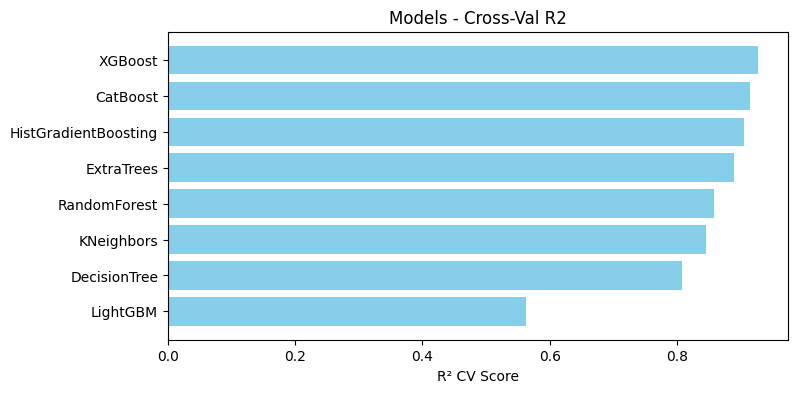

In [31]:
if SHOW_PLOTS:
    plt.figure(figsize=(8,4))
    plt.barh(results_df["Model"], results_df["Best Score (CV)"], color='skyblue')
    plt.gca().invert_yaxis()
    plt.xlabel("R² CV Score")
    plt.title("Models - Cross-Val R2")
    plt.show()

### FEATURE EXPLORATION

In [36]:
# Suppose 'results_df' is the DataFrame from your cross‑validation search.
# For illustration, we choose the best LightGBM model from results_df.
# (Alternatively, you can choose any tree‑based estimator that has a feature_importances_ attribute.)
best_model_row = results_df[results_df["Model"]=="LightGBM"].iloc[0]
best_model = best_model_row["Best Estimator"]

# Ensure that the training feature matrix X and the feature names are defined.
# (Here, final_feature_cols is your global list of feature names.)
print("Using best LightGBM model from CV for feature importance probing.")
print("Final feature columns:", final_feature_cols)

# ----------------------------
# 1. Model-based Feature Importances
# ----------------------------
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    feat_imp_df = pd.DataFrame({
        'feature': final_feature_cols,
        'importance': importances
    }).sort_values(by='importance', ascending=False)
    print("\n=== Model-Based Feature Importances (LightGBM) ===")
    print(feat_imp_df)
else:
    print("The chosen model does not have a feature_importances_ attribute.")

# ----------------------------
# 2. Permutation Importance (Model-Agnostic)
# ----------------------------
from sklearn.inspection import permutation_importance

print("\nComputing permutation importance...")
perm_result = permutation_importance(
    best_model, X, y, scoring='r2', n_repeats=10, random_state=RANDOM_SEED
)
perm_imp_df = pd.DataFrame({
    'feature': final_feature_cols,
    'importance_mean': perm_result.importances_mean,
    'importance_std': perm_result.importances_std
}).sort_values(by='importance_mean', ascending=False)
print("\n=== Permutation Feature Importances ===")
print(perm_imp_df)

# ----------------------------
# 3. SHAP Values (for detailed local/global explanations)
# ----------------------------
# Uncomment the block below if you wish to compute SHAP values.
# Note: SHAP can be computationally intensive.

import shap

# Create a SHAP explainer for the model.
# For tree-based models, TreeExplainer is usually fast.
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X)

# Summary plot: This will produce an interactive (or static) plot of feature importance.
print("\nGenerating SHAP summary plot...")
shap.summary_plot(shap_values, X, feature_names=final_feature_cols)

# You can also compute mean absolute SHAP values:
shap_imp = np.abs(shap_values).mean(axis=0)
shap_imp_df = pd.DataFrame({
    'feature': final_feature_cols,
    'mean_abs_shap': shap_imp
}).sort_values(by='mean_abs_shap', ascending=False)
print("\n=== Mean Absolute SHAP Values ===")
print(shap_imp_df)

Using best LightGBM model from CV for feature importance probing.
Final feature columns: ['building_cov_50m', 'building_cov_100m', 'building_cov_200m', 'building_cov_500m', 'distance_water', 'distance_parks', 'street_tree_cov_500m', 'dist_to_closest_subway_station', 'lst_value', 'ndvi_value', 'ndbi_value', 'ndwi_value', 'NumBldgs', 'NumFloors', 'UnitsRes', 'UnitsTotal', 'LotArea', 'BldgArea', 'ComArea', 'ResArea', 'AssessLand', 'AssessTot', 'ExemptTot', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'YearBuilt', 'YearAlter1', 'YearAlter2', 'Overlay1_C1-3', 'Overlay1_C1-4', 'Overlay1_C1-5', 'Overlay1_C2-4', 'Overlay1_C2-5', 'Overlay1_None', 'Overlay1_nan', 'SPDist1_125th', 'SPDist1_C', 'SPDist1_CL', 'SPDist1_EC-2', 'SPDist1_EC-3', 'SPDist1_EHC', 'SPDist1_HP', 'SPDist1_J', 'SPDist1_L', 'SPDist1_MMU', 'SPDist1_MP', 'SPDist1_MX-1', 'SPDist1_MX-13', 'SPDist1_MX-7', 'SPDist1_MiD', 'SPDist1_None', 'SPDist1_PI', 'SPDist1_TA', 'SPDist1_nan', 'LandUse_01', 'LandUse_02', 'LandUse_03', 'LandUse_04

KeyboardInterrupt: 

### VALIDATION DATA

In [60]:
print("Loading validation (submission) data...")
df_val = pd.read_csv("./data/Submission_template_UHI2025-v2.csv")

gdf_val = gpd.GeoDataFrame(
    df_val,
    geometry=[Point(lon, lat) for lon, lat in zip(df_val.Longitude, df_val.Latitude)],
    crs="EPSG:4326"
).to_crs("EPSG:2263")

Loading validation (submission) data...


### FEATURE ENGINEERING FOR VALIDATION SET

In [61]:
print("Building validation features...")

# Create a dictionary for per-point features (exclude the map_pluto_data flag)
features_dict_val = {key: [] for key, val in FEATURE_FLAGS.items() if val and key != "map_pluto_data"}

# Create a separate dictionary for PLUTO features
pluto_features_dict = {col: [] for col in pluto_columns}

total_rows_val = len(gdf_val)
print(f"total rows (validation): {total_rows_val}")

for idx, row in gdf_val.iterrows():
    if idx % 100 == 0:
        percent_val = (idx / total_rows_val) * 100
        print(f"  -> {percent_val:.2f}% val feature build...")
    geom = row.geometry

    # Per-point features
    if FEATURE_FLAGS["building_cov_50m"]:
        b50 = building_coverage_fraction(geom, gdf_buildings, 50)
        features_dict_val["building_cov_50m"].append(b50)
    if FEATURE_FLAGS["building_cov_100m"]:
        b100 = building_coverage_fraction(geom, gdf_buildings, 100)
        features_dict_val["building_cov_100m"].append(b100)
    if FEATURE_FLAGS["building_cov_200m"]:
        b200 = building_coverage_fraction(geom, gdf_buildings, 200)
        features_dict_val["building_cov_200m"].append(b200)
    if FEATURE_FLAGS["building_cov_500m"]:
        b500 = building_coverage_fraction(geom, gdf_buildings, 500)
        features_dict_val["building_cov_500m"].append(b500)
        
    if FEATURE_FLAGS["distance_water"]:
        dw = distance_to_polygons(geom, gdf_water)
        features_dict_val["distance_water"].append(dw)
    if FEATURE_FLAGS["distance_parks"]:
        dp = distance_to_polygons(geom, gdf_parks)
        features_dict_val["distance_parks"].append(dp)
    if FEATURE_FLAGS["street_tree_cov_500m"]:
        tree_500 = coverage_fraction(geom, gdf_trees_poly, 500)
        features_dict_val["street_tree_cov_500m"].append(tree_500)
    if FEATURE_FLAGS["dist_to_closest_subway_station"]:
        dists_sub = gdf_stations.geometry.distance(geom)
        dist_sub = dists_sub.min() if len(dists_sub) > 0 else 0
        features_dict_val["dist_to_closest_subway_station"].append(dist_sub)
    if FEATURE_FLAGS["lst_value"]:
        lv = extract_raster_value(geom, lst_raster_2263, band_index=1)
        features_dict_val["lst_value"].append(lv)
    if FEATURE_FLAGS["ndvi_value"]:
        ndvi_val = extract_raster_value(geom, indices_raster_2263, band_index=1)
        features_dict_val["ndvi_value"].append(ndvi_val)
    if FEATURE_FLAGS["ndbi_value"]:
        ndbi_val = extract_raster_value(geom, indices_raster_2263, band_index=2)
        features_dict_val["ndbi_value"].append(ndbi_val)
    if FEATURE_FLAGS["ndwi_value"]:
        ndwi_val = extract_raster_value(geom, indices_raster_2263, band_index=3)
        features_dict_val["ndwi_value"].append(ndwi_val)
    
    # PLUTO features (row-by-row extraction)
    if FEATURE_FLAGS["map_pluto_data"]:
        pluto_feats = get_pluto_features(geom, gdf_pluto, pluto_columns)
        for col in pluto_columns:
            pluto_features_dict[col].append(pluto_feats.get(col, np.nan))

print("100.00% done building validation features.")

Building validation features...
total rows (validation): 1040
  -> 0.00% val feature build...
  -> 9.62% val feature build...
  -> 19.23% val feature build...
  -> 28.85% val feature build...
  -> 38.46% val feature build...
  -> 48.08% val feature build...
  -> 57.69% val feature build...
  -> 67.31% val feature build...
  -> 76.92% val feature build...
  -> 86.54% val feature build...
  -> 96.15% val feature build...
100.00% done building validation features.


In [62]:
# --- Add per-point features to the validation DataFrame (df_val)
for feat_key, feat_values in features_dict_val.items():
    df_val[feat_key] = feat_values
    print(f"Per-point: {feat_key}: {len(feat_values)}")

# --- Add PLUTO features to df_val
for col, values in pluto_features_dict.items():
    df_val[col] = values
    print(f"PLUTO: {col}: {len(values)}")

# --- Process categorical PLUTO columns via one-hot encoding
# Define the categorical columns (same as used in training)
map_pluto_cat_cols = ["Overlay1", "SPDist1", "LandUse", "BldgClass", "ZoneDist1"]
for col in map_pluto_cat_cols:
    df_val[col] = df_val[col].astype(str)

# One-hot encode these categorical columns on validation data
pluto_dummies_val = pd.get_dummies(df_val[map_pluto_cat_cols], prefix=map_pluto_cat_cols)

# Reindex validation dummies to match training dummy columns.
# It is assumed that dummy_cols_train was stored from training.
try:
    dummy_cols_train
except NameError:
    # If not available, set it to the columns from the training dummy DataFrame.
    dummy_cols_train = list(pluto_dummies_val.columns)
pluto_dummies_val = pluto_dummies_val.reindex(columns=dummy_cols_train, fill_value=0)

# Drop the original categorical columns and concatenate the dummy columns.
df_val = df_val.drop(columns=map_pluto_cat_cols)
df_val = pd.concat([df_val, pluto_dummies_val], axis=1)
print("One-hot encoded PLUTO categorical features added to validation data.")

# --- Build final global feature list for validation
# Per-point features (from features_dict_val)
per_point_features_val = list(features_dict_val.keys())
# PLUTO numeric features: those in pluto_columns that are not in the categorical list
pluto_numeric_features = [col for col in pluto_columns if col not in map_pluto_cat_cols]
# And dummy features from one-hot encoding:
pluto_dummy_features_val = list(pluto_dummies_val.columns)

final_feature_cols_val = per_point_features_val + pluto_numeric_features + pluto_dummy_features_val
print("Final feature columns for validation:")
print(final_feature_cols_val)

df_val_feat = df_val[final_feature_cols_val].fillna(0.0)
X_val = df_val_feat.values

print("Validation shape:", X_val.shape)
print("Feature columns:", final_feature_cols_val)

Per-point: building_cov_50m: 1040
Per-point: building_cov_100m: 1040
Per-point: building_cov_200m: 1040
Per-point: building_cov_500m: 1040
Per-point: distance_water: 1040
Per-point: distance_parks: 1040
Per-point: street_tree_cov_500m: 1040
Per-point: dist_to_closest_subway_station: 1040
Per-point: lst_value: 1040
Per-point: ndvi_value: 1040
Per-point: ndbi_value: 1040
Per-point: ndwi_value: 1040
PLUTO: NumBldgs: 1040
PLUTO: NumFloors: 1040
PLUTO: UnitsRes: 1040
PLUTO: UnitsTotal: 1040
PLUTO: LotArea: 1040
PLUTO: BldgArea: 1040
PLUTO: ComArea: 1040
PLUTO: ResArea: 1040
PLUTO: AssessLand: 1040
PLUTO: AssessTot: 1040
PLUTO: ExemptTot: 1040
PLUTO: BuiltFAR: 1040
PLUTO: ResidFAR: 1040
PLUTO: CommFAR: 1040
PLUTO: FacilFAR: 1040
PLUTO: YearBuilt: 1040
PLUTO: YearAlter1: 1040
PLUTO: YearAlter2: 1040
PLUTO: Overlay1: 1040
PLUTO: SPDist1: 1040
PLUTO: LandUse: 1040
PLUTO: BldgClass: 1040
PLUTO: ZoneDist1: 1040
One-hot encoded PLUTO categorical features added to validation data.
Final feature col

In [63]:
df_val_feat.describe()

,building_cov_50m,building_cov_100m,building_cov_200m,building_cov_500m,distance_water,distance_parks,street_tree_cov_500m,dist_to_closest_subway_station,lst_value,ndvi_value,...,ZoneDist1_C6-6,ZoneDist1_M1-2/R6A,ZoneDist1_M1-4,ZoneDist1_M1-4/R7X,ZoneDist1_M1-6/R10,ZoneDist1_R10H,ZoneDist1_R7B,ZoneDist1_R7D,ZoneDist1_R7X,ZoneDist1_R8A
count,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,...,1040.0,1040.0,1040.0,1040.0,1040.0,1040.0,1040.0,1040.0,1040.0,1040.0
mean,0.118962,0.228639,0.306988,0.326797,1862.946328,354.089910,0.001580,1343.433165,40.578069,-0.010139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.170540,0.183847,0.187521,0.163913,1291.951419,352.246984,0.000805,927.888462,2.662403,0.056343,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,37.485593,0.000000,0.000000,14.814218,33.171207,-0.193109,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.000000,0.062545,0.175813,0.215039,924.712590,74.049553,0.001006,735.051227,39.280917,-0.037819,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.042792,0.214779,0.317390,0.331559,1569.105207,284.669629,0.001600,1117.922503,40.776301,-0.021421,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.180471,0.357297,0.436838,0.434537,2394.165190,505.034117,0.002139,1737.766898,42.246904,0.003323,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.000000,0.998447,0.822876,0.674815,6009.848198,1989.277468,0.003548,5977.155473,54.564594,0.524535,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
df_val_feat

,building_cov_50m,building_cov_100m,building_cov_200m,building_cov_500m,distance_water,distance_parks,street_tree_cov_500m,dist_to_closest_subway_station,lst_value,ndvi_value,...,ZoneDist1_R7A,ZoneDist1_R7B,ZoneDist1_R7D,ZoneDist1_R7X,ZoneDist1_R8,ZoneDist1_R8A,ZoneDist1_R8B,ZoneDist1_R9,ZoneDist1_R9A,ZoneDist1_nan
0,0.000000,0.248892,0.417782,0.434283,1598.865845,16.915051,0.002833,1261.529232,40.178148,-0.051394,...,False,0,0,0,False,0,False,False,False,True
1,0.002853,0.167185,0.401631,0.434841,1680.392927,17.191011,0.002616,1190.837376,40.178148,-0.039764,...,False,0,0,0,False,0,False,False,False,True
2,0.909268,0.685125,0.469204,0.393609,548.782831,171.943979,0.001872,1143.271023,38.168352,-0.044698,...,False,0,0,0,False,0,False,False,False,False
3,0.478154,0.505082,0.524747,0.419828,1867.133018,148.747368,0.002479,1028.151027,40.311450,-0.012213,...,False,0,0,0,False,0,False,False,False,False
4,0.235512,0.576894,0.712504,0.645928,996.831598,407.007100,0.002761,789.915025,38.130754,-0.025760,...,False,0,0,0,False,0,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035,0.117659,0.374859,0.371426,0.425470,3414.672802,402.099179,0.001819,953.712505,44.901851,-0.076566,...,False,0,0,0,False,0,False,False,False,True
1036,0.029740,0.119606,0.250616,0.235188,674.384502,97.740724,0.001466,2274.339527,39.904706,-0.018511,...,False,0,0,0,False,0,False,False,False,False
1037,0.012397,0.215837,0.468919,0.400809,1723.423905,574.938724,0.001841,1385.796145,41.237734,0.072678,...,False,0,0,0,False,0,False,False,False,True
1038,0.166023,0.423393,0.377644,0.422928,4002.581340,1176.932684,0.001072,293.362888,43.435521,-0.021245,...,False,0,0,0,False,0,False,False,False,False


In [65]:
df_val

,Longitude,Latitude,UHI Index,building_cov_50m,building_cov_100m,building_cov_200m,building_cov_500m,distance_water,distance_parks,street_tree_cov_500m,...,ZoneDist1_R7A,ZoneDist1_R7B,ZoneDist1_R7D,ZoneDist1_R7X,ZoneDist1_R8,ZoneDist1_R8A,ZoneDist1_R8B,ZoneDist1_R9,ZoneDist1_R9A,ZoneDist1_nan
0,-73.971665,40.788763,NaN,0.000000,0.248892,0.417782,0.434283,1598.865845,16.915051,0.002833,...,False,0,0,0,False,0,False,False,False,True
1,-73.971928,40.788875,NaN,0.002853,0.167185,0.401631,0.434841,1680.392927,17.191011,0.002616,...,False,0,0,0,False,0,False,False,False,True
2,-73.967080,40.789080,NaN,0.909268,0.685125,0.469204,0.393609,548.782831,171.943979,0.001872,...,False,0,0,0,False,0,False,False,False,False
3,-73.972550,40.789082,NaN,0.478154,0.505082,0.524747,0.419828,1867.133018,148.747368,0.002479,...,False,0,0,0,False,0,False,False,False,False
4,-73.969697,40.787953,NaN,0.235512,0.576894,0.712504,0.645928,996.831598,407.007100,0.002761,...,False,0,0,0,False,0,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035,-73.919388,40.813803,NaN,0.117659,0.374859,0.371426,0.425470,3414.672802,402.099179,0.001819,...,False,0,0,0,False,0,False,False,False,True
1036,-73.931033,40.833178,NaN,0.029740,0.119606,0.250616,0.235188,674.384502,97.740724,0.001466,...,False,0,0,0,False,0,False,False,False,False
1037,-73.934647,40.854542,NaN,0.012397,0.215837,0.468919,0.400809,1723.423905,574.938724,0.001841,...,False,0,0,0,False,0,False,False,False,True
1038,-73.917223,40.815413,NaN,0.166023,0.423393,0.377644,0.422928,4002.581340,1176.932684,0.001072,...,False,0,0,0,False,0,False,False,False,False


### ENSEMBLE: PICK TOP 3 MODELS

In [66]:
topN = results_df.head(3).reset_index(drop=True)
base_models = []
for i in range(len(topN)):
    mname = topN.loc[i, "Model"]
    mest = topN.loc[i, "Best Estimator"]
    base_models.append((mname, mest))

print("\nTop Models from CV:\n", base_models)

modelA, modelB, modelC = base_models[0][1], base_models[1][1], base_models[2][1]


Top Models from CV:
 [('XGBoost', XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=20, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)), ('CatBoost', <catboost.core.CatBoostRegressor object at 0x00000271C2A52C20>), ('HistGradientBoosting', HistGradientBoostingRegressor(l2_regularization=1.0, max_depth=30, max_iter=600,
                              max_l

### WEIGHTED SEARCH

In [67]:
from sklearn.model_selection import KFold
def search_ensemble_weights_3(modelA, modelB, modelC, X, y, skf, increments=0.001):
    """
    Find best weights w1, w2, w3 that sum to 1
    for an ensemble of (modelA, modelB, modelC).
    Minimizes over entire data via out-of-fold approach.
    """
    predsA_oof = np.zeros(len(X))
    predsB_oof = np.zeros(len(X))
    predsC_oof = np.zeros(len(X))

    for train_idx, valid_idx in skf.split(X, y_bins):
        XA, XV = X[train_idx], X[valid_idx]
        ya, yv = y[train_idx], y[valid_idx]

        ma = clone(modelA).fit(XA, ya)
        mb = clone(modelB).fit(XA, ya)
        mc = clone(modelC).fit(XA, ya)

        predsA_oof[valid_idx] = ma.predict(XV)
        predsB_oof[valid_idx] = mb.predict(XV)
        predsC_oof[valid_idx] = mc.predict(XV)

    best_combo, best_r2 = (0,0,0), -999

    # Count total iterations
    num_steps = int(1 / increments) + 1
    total_iterations = (num_steps * (num_steps + 1)) // 2  # Sum of arithmetic series
    iteration_count = 0
    last_reported_progress = 0
    
    for w1 in np.arange(0,1+increments,increments):
        for w2 in np.arange(0,1+increments,increments):
            w3 = 1 - w1 - w2
            if w3 < 0:
                continue
            blend = w1*predsA_oof + w2*predsB_oof + w3*predsC_oof
            r2_ens = r2_score(y, blend)
            if r2_ens > best_r2:
                best_r2 = r2_ens
                best_combo = (w1, w2, w3)
            # Track progress
            iteration_count += 1
            progress = (iteration_count / total_iterations) * 100
            if round(progress) > last_reported_progress:
                last_reported_progress = round(progress)
                print(f"Progress: {last_reported_progress}%")
    return best_combo, best_r2

In [68]:
# Weighted 3-model ensemble with fine increments
best_combo, best_r2 = search_ensemble_weights_3(modelA, modelB, modelC, X, y, skf, increments=0.1)
w1, w2, w3 = best_combo
print(f"\nBest 3-model weights => w1={w1:.3f}, w2={w2:.3f}, w3={w3:.3f}; OOF R²={best_r2:.5f}")

# Refit all on full data
finalA = clone(modelA).fit(X, y)
finalB = clone(modelB).fit(X, y)
finalC = clone(modelC).fit(X, y)

predA_val = finalA.predict(X_val)
predB_val = finalB.predict(X_val)
predC_val = finalC.predict(X_val)

final_ensemble_val = w1*predA_val + w2*predB_val + w3*predC_val
df_val["UHI Index"] = final_ensemble_val

submission_3model_path = "output/submission_v16_3model_weighted.csv"
os.makedirs("output", exist_ok=True)
df_val[["Longitude", "Latitude", "UHI Index"]].to_csv(submission_3model_path, index=False)
print(f"Saved 3-model weighted ensemble submission => {submission_3model_path}")

Progress: 2%
Progress: 3%
Progress: 5%
Progress: 6%
Progress: 8%
Progress: 9%
Progress: 11%
Progress: 12%
Progress: 14%
Progress: 15%
Progress: 17%
Progress: 18%
Progress: 20%
Progress: 21%
Progress: 23%
Progress: 24%
Progress: 26%
Progress: 27%
Progress: 29%
Progress: 30%
Progress: 32%
Progress: 33%
Progress: 35%
Progress: 36%
Progress: 38%
Progress: 39%
Progress: 41%
Progress: 42%
Progress: 44%
Progress: 45%
Progress: 47%
Progress: 48%
Progress: 50%
Progress: 52%
Progress: 53%
Progress: 55%
Progress: 56%
Progress: 58%
Progress: 59%
Progress: 61%
Progress: 62%
Progress: 64%
Progress: 65%
Progress: 67%
Progress: 68%
Progress: 70%
Progress: 71%
Progress: 73%
Progress: 74%
Progress: 76%
Progress: 77%
Progress: 79%
Progress: 80%
Progress: 82%
Progress: 83%
Progress: 85%
Progress: 86%
Progress: 88%
Progress: 89%
Progress: 91%

Best 3-model weights => w1=0.600, w2=0.300, w3=0.100; OOF R²=0.93149
Saved 3-model weighted ensemble submission => output/submission_v16_3model_weighted.csv


### SAVE THE WEIGHTED ENSEMBLE

In [69]:
import pickle

ensemble_dict = {
    "model_names": [base_models[0][0], base_models[1][0], base_models[2][0]],
    "models": [finalA, finalB, finalC],
    "weights": (w1, w2, w3)
}
os.makedirs("models", exist_ok=True)
with open("models/3model_weighted_ensemble_v16.pkl","wb") as f:
    pickle.dump(ensemble_dict, f)
print("Saved 3-model weighted ensemble with discovered weights (v16).")

Saved 3-model weighted ensemble with discovered weights (v16).


### ENSEMBLE WITH SIMPLE AVERAGE

In [70]:
val_predsA = modelA.predict(X_val)
val_predsB = modelB.predict(X_val)
val_predsC = modelC.predict(X_val)

avg3 = (val_predsA + val_predsB + val_predsC) / 3
df_val["UHI Index"] = avg3
submission_avg3_path = "output/submission_v16-avg3.csv"
df_val[["Longitude","Latitude","UHI Index"]].to_csv(submission_avg3_path, index=False)
print(f"Saved simple average => {submission_avg3_path}")

avg2 = (val_predsA + val_predsB) / 2
df_val["UHI Index"] = avg2
submission_avg2_path = "output/submission_v16-avg2.csv"
df_val[["Longitude","Latitude","UHI Index"]].to_csv(submission_avg2_path, index=False)
print(f"Saved simple average => {submission_avg2_path}")

df_val["UHI Index"] = val_predsA
submission_top1_path = "output/submission_v16-1.csv"
df_val[["Longitude","Latitude","UHI Index"]].to_csv(submission_top1_path, index=False)
print(f"Saved simple average => {submission_top1_path}")

Saved simple average => output/submission_v16-avg3.csv
Saved simple average => output/submission_v16-avg2.csv
Saved simple average => output/submission_v16-1.csv


### META-LEARNERS

In [71]:
print("\nGenerating OOF predictions for meta-learner...")
oof_preds = np.zeros((len(X), len(base_models)))
for idx, (mname, base_model) in enumerate(base_models):
    print(f"  -> Base model {idx}: {mname}")
    model_clone = clone(base_model)
    for train_idx, valid_idx in skf.split(X, y_bins):
        X_trainF, X_validF = X[train_idx], X[valid_idx]
        y_trainF, y_validF = y[train_idx], y[valid_idx]
        model_clone.fit(X_trainF, y_trainF)
        oof_preds[valid_idx, idx] = model_clone.predict(X_validF)

from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingRegressor

meta_learners = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=RANDOM_SEED),
    "Lasso": Lasso(alpha=1e-5, random_state=RANDOM_SEED),
    "XGB": xgb.XGBRegressor(n_estimators=300, learning_rate=0.05,
                            max_depth=10, random_state=RANDOM_SEED,
                            subsample=0.8, colsample_bytree=0.8,
                            eval_metric="rmse", use_label_encoder=False),
    "LightGBM": lgb.LGBMRegressor(n_estimators=300, learning_rate=0.05,
                                  num_leaves=31, max_depth=None, random_state=RANDOM_SEED),
    "RF": RandomForestRegressor(n_estimators=300, max_depth=10, random_state=RANDOM_SEED),
    "MLP": MLPRegressor(hidden_layer_sizes=(128,64), activation="relu",
                        solver="adam", max_iter=500, random_state=RANDOM_SEED)
}

scaler = StandardScaler()
X_oof_scaled = scaler.fit_transform(oof_preds)

meta_results = {}
for mname, meta_model in meta_learners.items():
    meta_model.fit(X_oof_scaled, y)
    preds_meta_oof = meta_model.predict(X_oof_scaled)
    r2_meta = r2_score(y, preds_meta_oof)
    meta_results[mname] = r2_meta

print("\n=== Meta-learner OOF R² comparison ===")
for mname, score_ in sorted(meta_results.items(), key=lambda x: x[1], reverse=True):
    print(f"{mname}: {score_:.5f}")

best_meta_name = max(meta_results, key=meta_results.get)
best_meta_model = meta_learners[best_meta_name]
print(f"\nBest meta-learner = {best_meta_name}, OOF R² => {meta_results[best_meta_name]:.5f}")

# Refit each base model on FULL data for final stack
base_models_fitted = []
full_preds_stack = np.zeros((len(X), len(base_models)))
for idx, (mname, base_model) in enumerate(base_models):
    fm = clone(base_model).fit(X, y)
    base_models_fitted.append((mname, fm))
    full_preds_stack[:, idx] = fm.predict(X)

# Refit meta-learner
full_preds_stack_scaled = scaler.transform(full_preds_stack)
final_meta_learner = clone(best_meta_model)
final_meta_learner.fit(full_preds_stack_scaled, y)
print("Refitted best meta-learner on entire dataset.")

# Validation predictions
val_stack = np.zeros((len(X_val), len(base_models_fitted)))
for idx, (mname, fm) in enumerate(base_models_fitted):
    val_stack[:, idx] = fm.predict(X_val)
val_stack_scaled = scaler.transform(val_stack)

final_val_preds_meta = final_meta_learner.predict(val_stack_scaled)
df_val["UHI Index"] = final_val_preds_meta

submission_meta_path = "output/submission_v16_meta.csv"
df_val[["Longitude","Latitude","UHI Index"]].to_csv(submission_meta_path, index=False)
print(f"Saved meta-learner submission => {submission_meta_path}")


Generating OOF predictions for meta-learner...
  -> Base model 0: XGBoost
  -> Base model 1: CatBoost
  -> Base model 2: HistGradientBoosting
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 11229, number of used features: 3
[LightGBM] [Info] Start training from score 0.999989

=== Meta-learner OOF R² comparison ===
XGB: 0.97727
RF: 0.96138
LightGBM: 0.95203
Linear: 0.93806
Ridge: 0.93806
Lasso: 0.93806
MLP: 0.91636

Best meta-learner = XGB, OOF R² => 0.97727
Refitted best meta-learner on entire dataset.
Saved meta-learner submission => output/submission_v16_meta.csv


### TWEAK MODEL APPOACH

In [72]:
# We'll do a 3-model OOF to confirm final ensemble => then tweak
predsA_oof = np.zeros(len(X))
predsB_oof = np.zeros(len(X))
predsC_oof = np.zeros(len(X))

for train_idx, valid_idx in skf.split(X,y_bins):
    XA, XV = X[train_idx], X[valid_idx]
    ya, yv = y[train_idx], y[valid_idx]
    
    foldA = clone(modelA).fit(XA, ya)
    foldB = clone(modelB).fit(XA, ya)
    foldC = clone(modelC).fit(XA, ya)

    predsA_oof[valid_idx] = foldA.predict(XV)
    predsB_oof[valid_idx] = foldB.predict(XV)
    predsC_oof[valid_idx] = foldC.predict(XV)

# wA, wB, wC = (0.3,0.4,0.3)  # or from search_ensemble_weights_3
ensemble_oof = w1*predsA_oof + w2*predsB_oof + w3*predsC_oof
residual_oof = y - ensemble_oof

# Tweak model:
tweak_model = DecisionTreeRegressor(max_depth=4).fit(X, residual_oof)

# Full-data refit
finalA = clone(modelA).fit(X,y)
finalB = clone(modelB).fit(X,y)
finalC = clone(modelC).fit(X,y)

predA_val = finalA.predict(X_val)
predB_val = finalB.predict(X_val)
predC_val = finalC.predict(X_val)

ensemble_val = w1*predA_val + w2*predB_val + w3*predC_val
residual_val = tweak_model.predict(X_val)
final_pred = ensemble_val + residual_val

df_val["UHI Index"] = final_pred
submission = df_val[["Longitude", "Latitude", "UHI Index"]]
submission_path = "output/submission_v16_tweak_3model.csv"
submission.to_csv(submission_path, index=False)
print(f"Saved {submission_path}")

Saved output/submission_v16_tweak_3model.csv


### SAVE TOP MODELS

In [73]:
# Save each base model
os.makedirs("models", exist_ok=True)
for i, (mname, fm) in enumerate(base_models_fitted):
    output_path = f"models/base_{mname}_model_{i}_v16.pkl"
    dump(fm, output_path)
    print(f"Saved base model: {output_path}")

# Save final meta-learner
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
meta_output_path = f"models/final_meta_learner_{best_meta_name}_{timestamp}.pkl"
dump(final_meta_learner, meta_output_path)
print(f"Saved final meta-learner ({best_meta_name}) => {meta_output_path}")

Saved base model: models/base_XGBoost_model_0_v16.pkl
Saved base model: models/base_CatBoost_model_1_v16.pkl
Saved base model: models/base_HistGradientBoosting_model_2_v16.pkl
Saved final meta-learner (XGB) => models/final_meta_learner_XGB_20250211_2350.pkl
